# Initialize data and required libraries

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

df = pd.read_csv("Full Air Pollution Data.csv")
df.head()

,SMSA,Pctover65,PopperHse,Education,PctGoodHse,NonWhite,WhiteCol,PctPoor,Mortality,popden,HC,NOX,SO2,State,Precip,AveJanTemp,AveJulTemp,Humidity
0,Akron,8.1,3.34,11.4,81.5,8.8,42.6,11.7,921.9,3243,21,15,59,OH,36,27,71,59
1,Albany,11.1,3.14,11.0,78.8,3.5,50.7,14.4,997.9,4281,8,10,39,NY,35,23,72,57
2,Allentown,10.4,3.21,9.8,81.6,0.8,39.4,12.4,962.4,4260,6,6,33,PA,44,29,74,54
3,Atlanta,6.5,3.41,11.1,77.5,27.1,50.2,20.6,982.3,3125,18,8,24,GA,47,45,79,56
4,Baltimore,7.6,3.44,9.6,84.6,24.4,43.7,14.3,1071.0,6441,43,38,206,MD,43,35,77,55


# Identify and set response, target variables

In [2]:
Y = df.loc[:, ('PctPoor', 'Mortality')]

X = df.drop(['PctPoor', 'Mortality', 'State', 'SMSA'], axis = 1)

ols = LinearRegression().fit(X, Y)
ols_predictions = ols.predict(X)
accuracy = np.sum(((Y - ols_predictions)**2)**(.5))
print("Regular OLS Accuracy:\n",accuracy)

Regular OLS Accuracy:
 PctPoor        67.967348
Mortality    1394.191760
dtype: float64


In [3]:
X.shape

(60, 14)

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA

q = 2

# Standardizing X and Y
X_tranformer = StandardScaler().fit(X)
X_scaled = X_tranformer.transform(X)
Y_tranformer = StandardScaler().fit(Y)
Y_scaled = Y_tranformer.transform(Y)

R = 12/699

# Computing CCA
cca = CCA(n_components = q)
cca.fit(X_scaled, Y_scaled)
X_c, Y_c = cca.transform(X_scaled, Y_scaled)
cs = np.corrcoef(X_c.T, Y_c.T).diagonal(offset = q)
T = cca.y_rotations_

Y.shape

(60, 2)

# Use preprocessing to predict

In [5]:
# Computing Diagonal Shrinkage
denom_1 = (cs**2)*((1 - R)**2)
denom_2 = (1 - cs**2)*(R**2)
numer = (1 - R)*(cs**2 - R)
ds = numer/(denom_1 + denom_2)
ds[ds < 0] = 0
D = np.diag(ds)

# Predicting values
ols_cw = LinearRegression().fit(X_scaled, Y_scaled)
Y_c_predictions = ols_cw.predict(X_scaled)
cw_predictions = Y_tranformer.inverse_transform(Y_c_predictions @ T @ D @ np.linalg.inv(T))
accuracy = np.sum(((Y - cw_predictions)**2))**(.5)

print("Curds and Whey Accuracy:\n", accuracy)

Curds and Whey Accuracy:
 PctPoor       10.750902
Mortality    231.890176
dtype: float64


# Review covariance matrix

In [6]:
import seaborn as sn
import matplotlib.pyplot as plt

covMatrix = pd.DataFrame.cov(X)
covMatrix.shape

(14, 14)

In [7]:
covMatrix

,Pctover65,PopperHse,Education,PctGoodHse,NonWhite,WhiteCol,popden,HC,NOX,SO2,Precip,AveJanTemp,AveJulTemp,Humidity
Pctover65,2.144912,-0.100842,-0.171910,0.680333,-8.333441,-0.795285,3.449764e+02,-2.759576,-0.141271,1.601299,1.471780,-5.928842,-3.027825,0.884181
PopperHse,-0.100842,0.018293,-0.045168,-0.284006,0.506063,-0.265619,-3.625270e+01,-4.829347,-2.246161,-0.035011,0.355483,-0.287743,0.168969,-0.098588
Education,-0.171910,-0.045168,0.714531,2.349740,-1.574373,2.742045,-2.997698e+02,22.301017,8.788814,-12.557175,-4.158305,0.999548,-0.960452,0.801130
PctGoodHse,0.680333,-0.284006,2.349740,25.780328,-19.511458,8.122141,1.184507e+03,180.335085,81.370000,35.267006,-25.047966,-0.111921,-10.467514,3.563277
NonWhite,-8.333441,0.506063,-1.574373,-19.511458,79.586881,-0.180559,-7.366288e+01,-21.223220,7.599492,90.082712,36.973390,41.165593,24.446610,-5.650847
WhiteCol,-0.795285,-0.265619,2.742045,8.122141,-0.180559,21.280167,-2.130770e+02,86.417542,34.205339,-20.019605,-13.791780,11.164096,-0.470480,1.503955
popden,344.976356,-36.252703,-299.769831,1184.506949,-73.662881,-213.077034,2.114414e+06,16087.143220,11137.611017,39828.096610,-20.848305,-1479.422881,-422.453390,-975.864407
HC,-2.759576,-4.829347,22.301017,180.335085,-21.223220,86.417542,1.608714e+04,8459.892373,4192.760169,1645.930508,-488.048305,328.116102,-156.182203,-9.966102
NOX,-0.141271,-2.246161,8.788814,81.370000,7.599492,34.205339,1.113761e+04,4192.760169,2146.773729,1202.425424,-225.248305,151.248305,-74.521186,-11.423729
SO2,1.601299,-0.035011,-12.557175,35.267006,90.082712,-20.019605,3.982810e+04,1645.930508,1202.425424,4018.351412,-67.205085,-69.495480,-29.997175,-34.909605


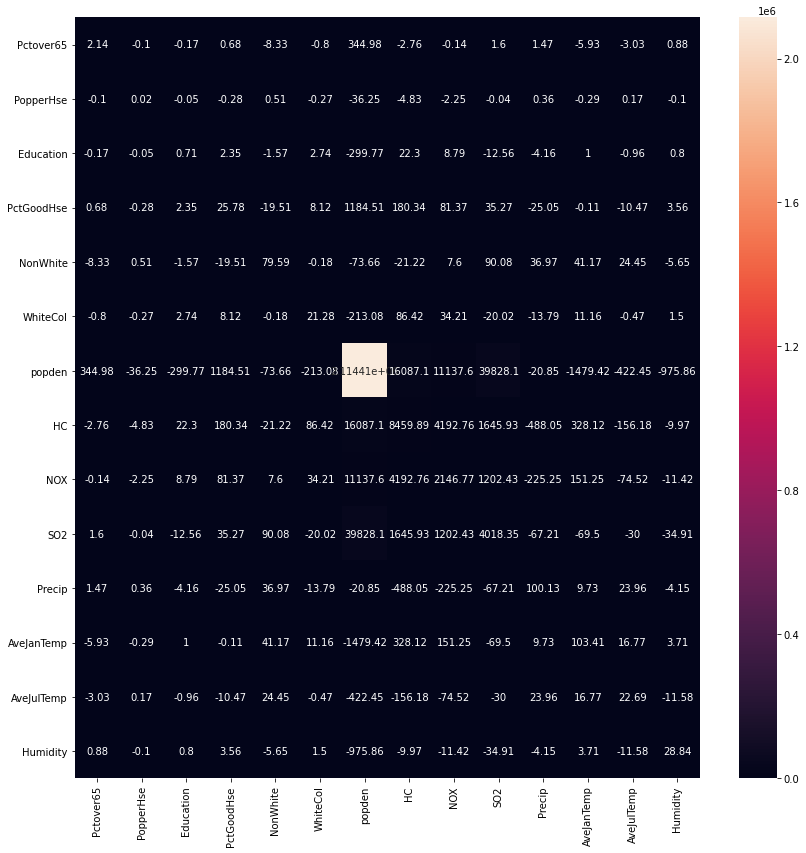

In [8]:
fig_dims = (14, 14)
fig, ax = plt.subplots(figsize=fig_dims)
sn.heatmap(covMatrix.round(2), annot = True, fmt = 'g', ax = ax)
plt.show()

# Compare PLS Results

In [9]:
from sklearn.cross_decomposition import PLSRegression

pls2 = PLSRegression()
pls2.fit(X, Y)

pls_pred = pls2.predict(X)

accuracy = np.sum(((Y - pls_pred)**2))**(.5)
print("PLS Accuracy (SSE):\n", accuracy)

PLS Accuracy (SSE):
 PctPoor       16.397489
Mortality    305.267346
dtype: float64


# Compare LARS Results

In [10]:
from sklearn import linear_model

reg = linear_model.Lars()
reg.fit(X, Y)

lars_preds = reg.predict(X)

accuracy = np.sum(((Y - lars_preds)**2))**(.5)
print("LARS Accuracy (SSE):\n", accuracy)

LARS Accuracy (SSE):
 PctPoor       11.482230
Mortality    238.159224
dtype: float64
